# Fitting

In [16]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# fitting
from scipy.optimize import curve_fit
from scipy.stats import crystalball

%matplotlib inline

form_title = {'family': 'helvetica', 'color': 'black', 'size': 15}
form_label = {'family': 'helvetica', 'color': 'black', 'size': 20}

In [2]:
data = pd.read_pickle('semileptonic_Bdecay_data.pkl')
data

__experiment__  __run__  __event__  __production__  \
charged 0                 1003        0    8640457           24816   
        1                 1003        0    8640457           24816   
        2                 1003        0    8640457           24816   
        12                1003        0   12624230           24816   
        13                1003        0   12624230           24816   
...                        ...      ...        ...             ...   
mixed   431043            1003        0     308753           25056   
        431044            1003        0     308753           25056   
        431045            1003        0    1175564           25056   
        431046            1003        0    1175564           25056   
        431048            1003        0    1175564           25056   

                __candidate__  __ncandidates__  __weight__       Ecms  \
charged 0                   0                3         1.0  10.579557   
        1                   1                3         1.0  10.579557   
        2                   2                3         1.0  10.579557   
        12                  0                9         1.0  10.579557   
        13                  1                9         1.0  10.579557   
...                       ...              ...         ...        ...   
mixed   431043              7                9         1.0  10.579557   
        431044              8                9         1.0  10.579557   
        431045              0                9         1.0  10.579557   
        431046              1                9         1.0  10.579557   
        431048              3                9         1.0  10.579557   

                aBminusMode  aBplusMode  ...  MCGenPDG_45  MCGenMothIndex_45  \
charged 0         -101002.0      1021.0  ...          NaN                NaN   
        1         -101002.0      1021.0  ...          NaN                NaN   
        2         -101002.0      1021.0  ...          NaN                NaN   
        12        -101001.0      1022.0  ...          NaN                NaN   
        13        -101001.0      1022.0  ...          NaN                NaN   
...                     ...         ...  ...          ...                ...   
mixed   431043        -99.0       -99.0  ...          NaN                NaN   
        431044        -99.0       -99.0  ...          NaN                NaN   
        431045        -99.0       -99.0  ...          NaN                NaN   
        431046        -99.0       -99.0  ...          NaN                NaN   
        431048        -99.0       -99.0  ...          NaN                NaN   

                MCGenPDG_46  MCGenMothIndex_46  MCGenPDG_47  \
charged 0               NaN                NaN          NaN   
        1               NaN                NaN          NaN   
        2               NaN                NaN          NaN   
        12              NaN                NaN          NaN   
        13              NaN                NaN          NaN   
...                     ...                ...          ...   
mixed   431043          NaN                NaN          NaN   
        431044          NaN                NaN          NaN   
        431045          NaN                NaN          NaN   
        431046          NaN                NaN          NaN   
        431048          NaN                NaN          NaN   

                MCGenMothIndex_47  MCGenPDG_48  MCGenMothIndex_48  \
charged 0                     NaN          NaN                NaN   
        1                     NaN          NaN                NaN   
        2                     NaN          NaN                NaN   
        12                    NaN          NaN                NaN   
        13                    NaN          NaN                NaN   
...                           ...          ...                ...   
mixed   431043                NaN          NaN                NaN   
        431044              

In [3]:
# reconstructed eta modes plus etaSB
l_eta_Bp = [1600,1700,2600,2700]
eta_Bp = list(i+1 for i in l_eta_Bp) + l_eta_Bp

l_eta_B0 = [1400,1500,2400,2500]
eta_B0 = list(i+1 for i in l_eta_B0) + l_eta_B0
eta_Bp, eta_B0

([1601, 1701, 2601, 2701, 1600, 1700, 2600, 2700],
 [1401, 1501, 2401, 2501, 1400, 1500, 2400, 2500])

In [5]:
# eta and etaSB modes reconstruction
df_eta_Bp = data.loc['charged'].query(
    f'((B0_decayModeID=={eta_Bp} & B1_decayModeID<500) | (B1_decayModeID=={eta_Bp} & B0_decayModeID<500))'
)

df_eta_B0 = data.loc['mixed'].query(
    f'((B0_decayModeID=={eta_B0} & B1_decayModeID<500) | (B1_decayModeID=={eta_B0} & B0_decayModeID<500))'
)

In [6]:
# eta
# splitting signal and background ****charged B****

# background
dfp_bkg = df_eta_Bp.drop(
    df_eta_Bp[
        ( ((df_eta_Bp['aBplusMode']%10000).isin([1019,1020,1039,1040])) | (abs(df_eta_Bp['aBminusMode'])%10000).isin([1019,1020,1039,1040]) )
        &( (df_eta_Bp['pi4_B0_isSignal']==1) | (df_eta_Bp['pi4_B1_isSignal']==1) ) 
    ].index, inplace=False
)

# splitting peaking and combinatoprial background
dfp_pkbkg = dfp_bkg[
    ( (~(dfp_bkg['aBplusMode']%10000).isin([1019,1020,1039,1040])) & (~(abs(dfp_bkg['aBminusMode'])%10000).isin([1019,1020,1039,1040])) )
    &( (dfp_bkg['pi4_B0_isSignal']==1) | (dfp_bkg['pi4_B1_isSignal']==1) ) 
]

dfp_combkg = dfp_bkg.drop(
    dfp_bkg[
        ( (~(dfp_bkg['aBplusMode']%10000).isin([1019,1020,1039,1040])) & (~(abs(dfp_bkg['aBminusMode'])%10000).isin([1019,1020,1039,1040])) )
        &( (dfp_bkg['pi4_B0_isSignal']==1) | (dfp_bkg['pi4_B1_isSignal']==1) )
    ].index
)

# signal
dfp_sig = df_eta_Bp[
    ( ((df_eta_Bp['aBplusMode']%10000).isin([1019,1020,1039,1040])) | (abs(df_eta_Bp['aBminusMode'])%10000).isin([1019,1020,1039,1040]) )
    &( (df_eta_Bp['pi4_B0_isSignal']==1) | (df_eta_Bp['pi4_B1_isSignal']==1) ) 
]


dfp = pd.concat([dfp_sig, dfp_pkbkg, dfp_combkg], keys=['signal', 'peaking background', 'combinatorial background'])

In [7]:
# eta
# splitting signal and background ****mixed B****

# background
df0_bkg = df_eta_B0.drop(
    df_eta_B0[
        ( ((df_eta_B0['aB0Mode']%10000).isin([1017,1018,1035,1036])) | (abs(df_eta_B0['aBbar0Mode'])%10000).isin([1017,1018,1035,1036]) )
        &( (df_eta_B0['pi4_B0_isSignal']==1) | (df_eta_B0['pi4_B1_isSignal']==1) ) 
    ].index, inplace=False
)

# solitting peaking and combinatoprial background
df0_pkbkg = df0_bkg[
    ( (~(df0_bkg['aB0Mode']%10000).isin([1017,1018,1035,1036])) & (~(abs(df0_bkg['aBbar0Mode'])%10000).isin([1017,1018,1035,1036])) )
    &( (df0_bkg['pi4_B0_isSignal']==1) | (df0_bkg['pi4_B1_isSignal']==1) ) 
]

df0_combkg = df0_bkg.drop(
    df0_bkg[
        ( (~(df0_bkg['aB0Mode']%10000).isin([1017,1018,1035,1036])) & (~(abs(df0_bkg['aBbar0Mode'])%10000).isin([1017,1018,1035,1036])) )
        &( (df0_bkg['pi4_B0_isSignal']==1) | (df0_bkg['pi4_B1_isSignal']==1) )
    ].index
)

# signal
df0_sig = df_eta_B0[
    ( ((df_eta_B0['aB0Mode']%10000).isin([1017,1018,1035,1036])) | (abs(df_eta_B0['aBbar0Mode'])%10000).isin([1017,1018,1035,1036]) )
    &( (df_eta_B0['pi4_B0_isSignal']==1) | (df_eta_B0['pi4_B1_isSignal']==1) ) 
]

df0 = pd.concat([df0_sig, df0_pkbkg, df0_combkg], keys=['signal', 'peaking background', 'combinatorial background'])

In [8]:
# combining the charged and mixed data set
# eta
df = pd.concat([dfp,df0])

In [9]:
# plotting the invariant mass of eta for both signal and background
# Note: signal is the combination of signal and peaking background

# Invariant mass of eta: signal + peaking background of both B0 and B1

# eta
eta_sig_InvM = pd.concat(
    [
        df.loc['signal']['pi4_B0_InvM'],df.loc['signal']['pi4_B1_InvM'],
        df.loc['peaking background']['pi4_B0_InvM'],df.loc['peaking background']['pi4_B1_InvM']
    ]
)
# Invariant mass of eta: combinatorial background of both B0 and B1
eta_bkg_InvM = pd.concat([df.loc['combinatorial background']['pi4_B0_InvM'],df.loc['combinatorial background']['pi4_B1_InvM']])

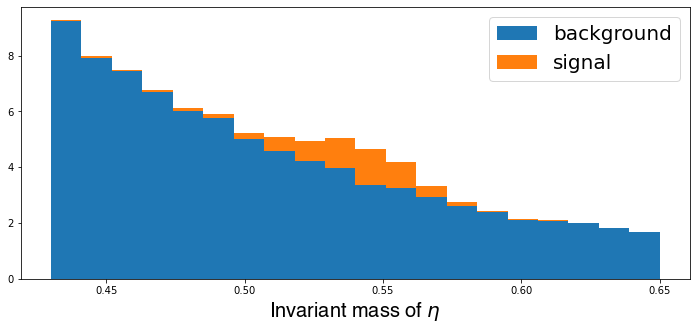

In [14]:
plt.figure(figsize=(12, 5))
bin_value, bin_edge, _ = plt.hist([eta_bkg_InvM,eta_sig_InvM],label=['background','signal'], histtype='barstacked',density=True, bins=20)
plt.xlabel('Invariant mass of $\eta$', fontdict=form_label)
plt.legend(fontsize='20')

## Using curve_fit

In [86]:
# exponential distribution
def exp_curve(x, a, b, c):
    return ( a * np.exp(b * x) + c )

157.0 1557.0 13.35185719564416


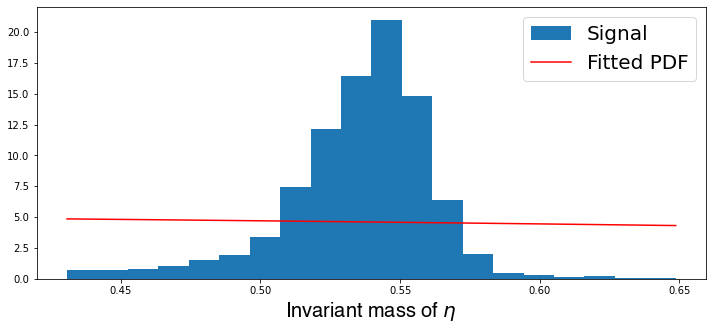

In [97]:
plt.figure(figsize=(12,5))
data = eta_sig_InvM.dropna()

# Create a histogram of the data
counts, edges, _ = plt.hist(data, bins=20, density=True, label='Signal')

# Define the Crystal Ball PDF function
def crystalball_pdf(x, beta, m, norm):
    return norm * crystalball.pdf(x, beta, m)

# Find the optimal parameters for the PDF using curve_fit
x_data = (edges[:-1] + edges[1:]) / 2
y_data = counts
popt, pcov = curve_fit(crystalball_pdf, x_data, y_data, p0=[157,1557, 13])
beta_fit, m_fit, norm_fit = popt
print(*popt)

# Plot the histogram and fitted PDF
x_vals = np.linspace(np.min(edges), np.max(edges), 20)
plt.plot(x_vals, crystalball_pdf(x_vals, *popt), 'r-', label='Fitted PDF')
plt.xlabel('Invariant mass of $\eta$', fontdict=form_label)
plt.legend(fontsize='20')

<font color='red'>beta:<font color='blue'> the value of the tail parameter longer tail on the left (negative skew), a smaller value of beta may be appropriate, longer tail on the right (positive skew), a larger value of beta may be appropriate.

<font color='red'>m<font color='blue'> : the value of the shape parameter based on the kurtosis of the data. If the data has heavier tails and a more peaked distribution (higher kurtosis), a larger value of m may be appropriate.

optimal parameters:  [1.57430191e+02 1.55743743e+03 2.63385790e+03 5.40981176e-01
 1.82348307e-02]


/Users/sahargholipour/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


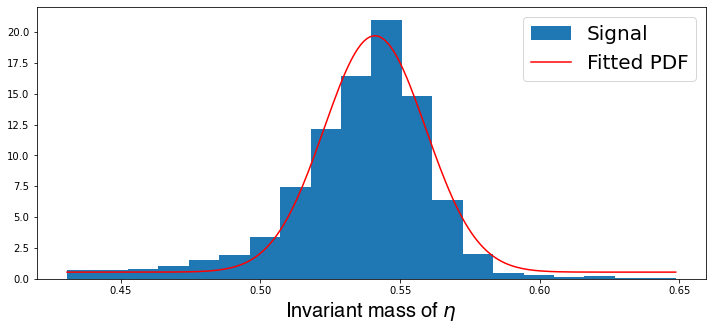

In [104]:
plt.figure(figsize=(12,5))
# data invariant mass of eta signal (signal + peaking background)
data = eta_sig_InvM.dropna()

# plot the histogram
counts, edges, _ = plt.hist(data, bins=20, density=True, label='Signal')
# getting the middle of each bin to make length of counts and edges the same
x_data = (edges[:-1] + edges[1:]) / 2
y_data = counts

# estimate the location and the scale of the distribution which are mean and standard deviation respectively
loc = np.mean(data)
scale = np.std(data)

def crystalball_f(x, beta, m, norm, mu, sigma):
    return norm * crystalball.pdf((x - mu) / sigma, beta, m) * sigma + mu

# Initial parameter estimates
beta0 = 2.0
m0 = 3.0
norm0 = 1.0
mu0 = loc
sigma0 = scale

p0 = [beta0, m0, norm0, mu0, sigma0]

# Fit Crystal Ball function to data
params, pcov = curve_fit(crystalball_f, x_data, y_data, p0)
beta_eta, m_eta , norm_eta, mu_eta, sigma_eta = params
print('optimal parameters: ',params)


# Plot the histogram and fitted PDF
x_vals = np.linspace(np.min(edges), np.max(edges), 200)
plt.plot(x_vals, crystalball_f(x_vals, *params), 'r-', label='Fitted PDF')
plt.xlabel('Invariant mass of $\eta$', fontdict=form_label)
plt.legend(fontsize='20')

In [82]:
y = lambda x : crystalball_f(x, beta=params[0],m=params[1],norm=params[2],mu=params[3],sigma=params[4])

In [83]:
# checking if the number of enteries in pdf function and the histogram are the same
import scipy.integrate as integrate

print('eta: \nThe area under the pdf function: ',integrate.quad(y,np.min(x_vals), np.max(x_vals))[0])
# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and mult by bin width, which can be factored out
integral = bin_width * sum(counts[:])
print('The area of the histogram: ', integral)

eta: 
The area under the pdf function:  0.9937013382005413
The area of the histogram:  1.0000000000000016


[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


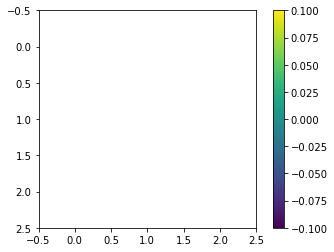

In [85]:
# looking at the covariance matrix
print(pcov)
plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()

In [73]:
mean, var, skew, kurt = crystalball.stats(2, 3, moments='mvsk')
skew

array(nan)

### Another way of fiding the best fit to the histogram (using the built_in function Fitter in Python)

In [44]:
# normalizing the eta_sig_InM values
from sklearn import preprocessing

# removing nan
cleanedList = [x for x in eta_sig_InvM if str(x) != 'nan']

normalized_arr = preprocessing.normalize([cleanedList])
print(normalized_arr)

[[0.01631044 0.01681985 0.01681985 ... 0.01633563 0.01709324 0.01709324]]


Fitting 1 distributions: 100%|████████████████████| 1/1 [00:00<00:00,  3.35it/s]

best fit:  {'crystalball': {'beta': 6.874131935657582, 'm': 5.52359400467754, 'loc': 0.5354250673682897, 'scale': 0.026659854875006953}}
Identifying the parameters:  (6.874131935657582, 5.52359400467754, 0.5354250673682897, 0.026659854875006953)


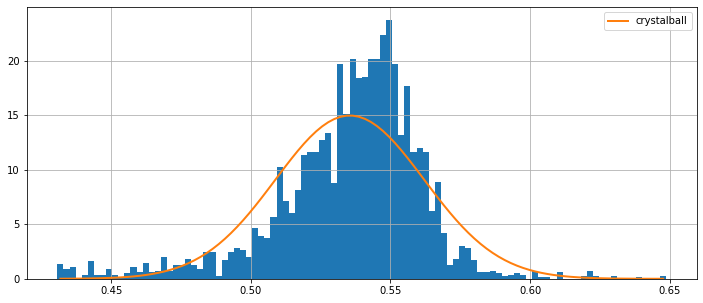

In [98]:
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
plt.figure(figsize=(12,5))

f = Fitter(
    cleanedList,
    distributions=['crystalball']
)

f.fit()
f.summary()
print('best fit: ', f.get_best(method='bic'))
print('Identifying the parameters: ', f.fitted_param["crystalball"])

In [103]:
# background
# Fit the function a * np.exp(b * x) + c to x_data and y_data
popt, pcov = curve_fit(lambda x,a,b,c: a * np.exp(b * x) + c, x_data, bin_value[0])
a_eta, b_eta, c_eta = popt
print(popt)

[ 5.65427011e+02 -9.60739205e+00  4.86521523e-01]


## Signal and Background to fit

The area below the PDF function:  1.0025248501377284
The area of the histogram:  0.990837633265723


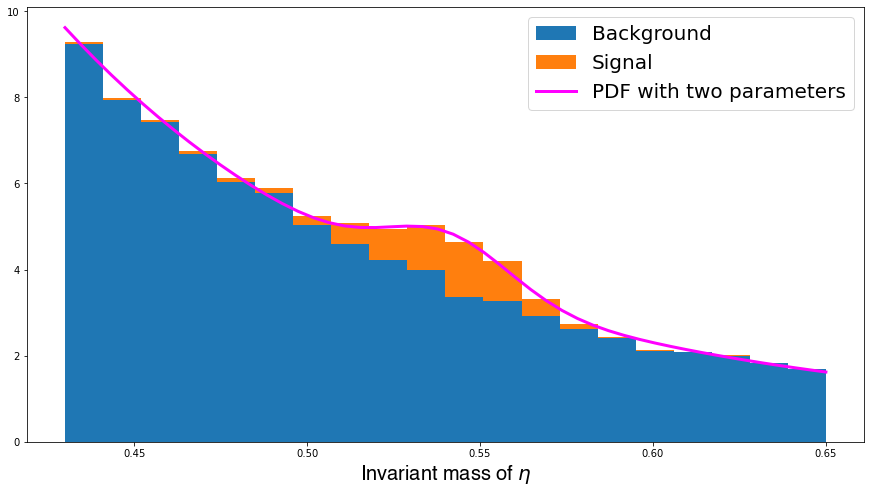

In [106]:
y_data = bin_value[0]+(bin_value[1]-bin_value[0])
x_data = x_data

# with two parameters
popt, pcov = curve_fit(lambda x,p1,p2: p1*crystalball_f(x,beta_eta,m_eta,norm_eta,mu_eta,sigma_eta) + p2*exp_curve(x,a_eta,b_eta,c_eta), x_data, y_data)
p1 = popt[0]
p2 = popt[1]

x_fitted = np.linspace(np.min(bin_edge), np.max(bin_edge))
y_fitted = lambda x: p1*crystalball_f(x,beta_eta,m_eta,norm_eta,mu_eta,sigma_eta) + p2*exp_curve(x,a_eta,b_eta,c_eta)

print('The area below the PDF function: ', integrate.quad(y_fitted,np.min(x_fitted),np.max(x_fitted))[0])
print('The area of the histogram: ', bin_width*sum(y_data[:]))

plt.figure(figsize=(15,8))
plt.hist([eta_bkg_InvM, eta_sig_InvM], bins=20, histtype='barstacked', density=True, label=['Background', 'Signal'])
plt.plot(x_fitted,y_fitted(x_fitted), color='fuchsia', linewidth=3, label='PDF with two parameters')
plt.xlabel('Invariant mass of $\eta$', fontdict=form_label)
plt.legend(fontsize='20')